In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import math

from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import random
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(41) # Seed 고정

In [3]:
train_df = pd.read_csv('./data/train.csv')
train_df = train_df.drop(columns=['ID'])

val_df = pd.read_csv('./data/val.csv')
val_df = val_df.drop(columns=['ID'])

test_df = pd.read_csv('./data/test.csv')
test_df = test_df.drop(columns=['ID'])

new_train_df = train_df[['V2','V3','V4','V7','V9','V10','V11','V12','V14','V16','V17','V18']]
new_val_df = val_df[['V2','V3','V4','V7','V9','V10','V11','V12','V14','V16','V17','V18','Class']]
new_test_df = test_df[['V2','V3','V4','V7','V9','V10','V11','V12','V14','V16','V17','V18']]

In [6]:
ratio = val_df['Class'].sum()/len(val_df)
ratio

0.0010540369615627855

# IsolationForest

In [7]:
def get_pred_label_IF(model_pred):
    # IsolationForest 모델 출력 (1:정상, -1:불량(사기)) 이므로 (0:정상, 1:불량(사기))로 Label 변환
    model_pred = np.where(model_pred == 1, 0, model_pred)
    model_pred = np.where(model_pred == -1, 1, model_pred)
    return model_pred

In [8]:
model_IF = IsolationForest(n_estimators=150, max_samples=len(new_train_df), contamination = ratio, max_features = 1, random_state=77)
model_IF.fit(new_train_df)

pred = model_IF.predict(new_val_df.drop('Class',axis = 1))
y = new_val_df['Class']

pred_IF = get_pred_label_IF(pred)
val_score = f1_score(y, pred_IF, average='macro')

print(f'Validation F1 Score : [{val_score}]')
print(classification_report(y, pred_IF))

/home/common/miniconda3/envs/jhoon/lib/python3.8/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Validation F1 Score : [0.785503270732222]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.62      0.53      0.57        30

    accuracy                           1.00     28462
   macro avg       0.81      0.77      0.79     28462
weighted avg       1.00      1.00      1.00     28462



In [9]:
pred = model_IF.predict(new_test_df)
pred_IF = get_pred_label_IF(pred)

In [10]:
np.count_nonzero(pred_IF > 0, axis=0)

259

# AutoEncoder

In [11]:
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [12]:
EPOCHS = 50
LR = 1e-2
BS = 16384 # 2의 제곱승꼴

In [13]:
class MyDataset(Dataset):
    def __init__(self, df, eval_mode):
        self.df = df
        self.eval_mode = eval_mode
        if self.eval_mode:
            self.labels = self.df['Class'].values
            self.df = self.df.drop(columns=['Class']).values
        else:
            self.df = self.df.values
        
    def __getitem__(self, index):
        if self.eval_mode:
            x = torch.from_numpy(self.df[index]).type(torch.FloatTensor)
            y = torch.FloatTensor([self.labels[index]])
            return x, y
            #self.x = self.df[index]
            #self.y = self.labels[index]
            #return torch.Tensor(self.x), self.y
        else:
            self.x = self.df[index]
            return torch.Tensor(self.x)
        
    def __len__(self):
        return len(self.df)

In [14]:
train_dataset = MyDataset(df=train_df, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True, num_workers=6)

val_dataset = MyDataset(df=val_df, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False, num_workers=6)

In [15]:
# 계층 정규화
class LayerNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-5):
        """Construct a layernorm module in the TF style (epsilon inside the square root).
        """
        super(LayerNorm, self).__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.bias = nn.Parameter(torch.zeros(hidden_size))
        self.variance_epsilon = eps

        self.init_weights()

    def init_weights(self):
        self.weight.data.fill_(1.0)
        self.bias.data.zero_()

    def forward(self, x):
        u = x.mean(-1, keepdim=True)
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon) # 계층정규화 완료
        return self.weight * x + self.bias # wx+b
        
# 활성화 함수
class GELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))
        
class AutoEncoder1(nn.Module):
    def __init__(self):
        super(AutoEncoder1, self).__init__()
        
        
        self.ln = LayerNorm(5000)
        self.ln1 = LayerNorm(3500)
        self.ln2 = LayerNorm(2000)
        self.ln3 = LayerNorm(1000)
        
        self.upblock1 = nn.Sequential(nn.Linear(30, 1000), nn.BatchNorm1d(1000),GELU())
        self.upblock2 = nn.Sequential(nn.Linear(1000,2000), nn.BatchNorm1d(2000),GELU())
        self.upblock3 = nn.Sequential(nn.Linear(2000,3500), nn.BatchNorm1d(3500),GELU())
        self.upblock4 = nn.Sequential(nn.Linear(3500,5000), nn.BatchNorm1d(5000),GELU())

        self.downblock1 = nn.Sequential(nn.Linear(5000, 3500),nn.BatchNorm1d(3500),GELU())
        self.downblock2 = nn.Sequential(nn.Linear(3500, 2000),nn.BatchNorm1d(2000),GELU())
        self.downblock3 = nn.Sequential(nn.Linear(2000, 1000),nn.BatchNorm1d(1000),GELU())
        self.downblock4 = nn.Sequential(nn.Linear(1000, 300),nn.BatchNorm1d(300),GELU())
        
        self.fclayer = nn.Sequential(nn.Linear(300,30))
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        upblock1_out = self.upblock1(x) 
        upblock2_out = self.upblock2(upblock1_out)
        upblock3_out = self.upblock3(upblock2_out)
        upblock4_out = self.upblock4(upblock3_out)
        
        downblock1_out = self.downblock1(self.ln(upblock4_out)) 
        skipblock1 = downblock1_out + upblock3_out
        downblock2_out = self.downblock2(self.ln1(skipblock1))
        skipblock2 = downblock2_out + upblock2_out
        downblock3_out = self.downblock3(self.ln2(skipblock2))
        skipblock3 = downblock3_out + upblock1_out 
        downblock4_out = self.downblock4(self.ln3(skipblock3))
        
        x = self.fclayer(downblock4_out)
         
        return x # 4

In [16]:
class Trainer():
    def __init__(self, model, optimizer, train_loader, val_loader, scheduler, device):
        self.model = model
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.scheduler = scheduler
        self.device = device
        # Loss Function
        self.criterion = nn.L1Loss().to(self.device)
        
    def fit(self):
        self.model.to(self.device)
        best_score = 0
        avg = 1
        for epoch in range(EPOCHS):
            self.model.train()
            train_loss = []
            for x in iter(self.train_loader):
                x = x.float().to(self.device)
                self.optimizer.zero_grad()

                _x = self.model(x)
                loss = self.criterion(x, _x)

                loss.backward()
                self.optimizer.step()

                train_loss.append(loss.item())

            score = self.validation(self.model, 0.95)
            print(f'Epoch : [{epoch}] Train loss : [{np.mean(train_loss)}] Val Score : [{score}])')

            if self.scheduler is not None:
                self.scheduler.step(score)

            if best_score <= score and avg > np.mean(train_loss):
                best_score = score
                avg = np.mean(train_loss)
                torch.save(model.module.state_dict(), './checkpoint/best_model.pth', _use_new_zipfile_serialization=False)
                print('---------------------------')
                print(f'Train loss : [{np.mean(train_loss)}] Val Score : [{score}])')
    
    def validation(self, eval_model, thr):
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        eval_model.eval()
        pred = []
        true = []
        with torch.no_grad():
            for x, y in iter(self.val_loader):
                x = x.float().to(self.device)

                _x = self.model(x)
                diff = cos(x, _x).cpu().tolist()
                batch_pred = np.where(np.array(diff)<thr, 1, 0).tolist()
                pred += batch_pred
                true += y.tolist()

        return f1_score(true, pred, average='macro')

In [17]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

model_autoencoder = nn.DataParallel(AutoEncoder1())
model_autoencoder.eval()
optimizer = torch.optim.Adam(params = model_autoencoder.parameters(), lr = LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)
trainer = Trainer(model_autoencoder, optimizer, train_loader, val_loader, scheduler, device)
trainer.fit()

Epoch : [0] Train loss : [0.5132853133337838] Val Score : [0.02092859841809397])
---------------------------
Train loss : [0.5132853133337838] Val Score : [0.02092859841809397])
Epoch : [1] Train loss : [0.2488231701510293] Val Score : [0.2906414832196451])
---------------------------
Train loss : [0.2488231701510293] Val Score : [0.2906414832196451])


Exception ignored in: <function _releaseLock at 0x7f2514153f70>
Traceback (most recent call last):
  File "/home/common/miniconda3/envs/jhoon/lib/python3.8/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


Epoch : [2] Train loss : [0.1722170923437391] Val Score : [0.48495470474700497])
---------------------------
Train loss : [0.1722170923437391] Val Score : [0.48495470474700497])
Epoch : [3] Train loss : [0.13155716338327952] Val Score : [0.506937276930102])
---------------------------
Train loss : [0.13155716338327952] Val Score : [0.506937276930102])


In [18]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

In [19]:
model_autoencoder = AutoEncoder1()
model_autoencoder.load_state_dict(torch.load('./checkpoint/best_model.pth'))
model_autoencoder = nn.DataParallel(model_autoencoder)
model_autoencoder.eval()

DataParallel(
  (module): AutoEncoder1(
    (ln): LayerNorm()
    (ln1): LayerNorm()
    (ln2): LayerNorm()
    (ln3): LayerNorm()
    (upblock1): Sequential(
      (0): Linear(in_features=30, out_features=1000, bias=True)
      (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU()
    )
    (upblock2): Sequential(
      (0): Linear(in_features=1000, out_features=2000, bias=True)
      (1): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU()
    )
    (upblock3): Sequential(
      (0): Linear(in_features=2000, out_features=3500, bias=True)
      (1): BatchNorm1d(3500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU()
    )
    (upblock4): Sequential(
      (0): Linear(in_features=3500, out_features=5000, bias=True)
      (1): BatchNorm1d(5000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU()
    )
    (downblock1): Sequentia

In [20]:
test_dataset = MyDataset(test_df, False)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False, num_workers=6)

In [81]:
def prediction_test(model, thr, test_loader, device):
    model.to(device)
    model.eval()
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    pred = []
    with torch.no_grad():
        for x in iter(test_loader):
            x = x.float().to(device)
            _x = model(x)
            
            diff = cos(x, _x).cpu().tolist()
            batch_pred = np.where(np.array(diff)<thr, 1,0).tolist()
            pred += batch_pred
    return pred

In [79]:
def prediction_val(model, thr, val_loader, device):
    model.to(device)
    model.eval()
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    pred = []
    with torch.no_grad():
        for x in iter(val_loader):
            x = x[0].float().to(device)
            _x = model(x)
            
            diff = cos(x, _x).cpu().tolist()
            batch_pred = np.where(np.array(diff)<thr, 1,0).tolist()
            pred += batch_pred
    return pred

In [82]:
pred_autoencoder = prediction_test(model_autoencoder, 0.95, test_loader, device)

In [83]:
pred_autoencoder = prediction_val(model_autoencoder, 0.95, val_loader, device)

In [84]:
pred_autoencoder.count(1)

30

# EllipticEnvelope

In [24]:
from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import SGDOneClassSVM
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline

In [25]:
def get_pred_label_ell(model_pred):
    # IsolationForest 모델 출력 (1:정상, -1:불량(사기)) 이므로 (0:정상, 1:불량(사기))로 Label 변환
    model_pred = np.where(model_pred == 1, 0, model_pred)
    model_pred = np.where(model_pred == -1, 1, model_pred)
    return model_pred

In [26]:
model_ell = EllipticEnvelope(support_fraction = 0.994, contamination = 0.00112, random_state = 42)
model_ell.fit(train_df)
val_x = val_df.drop(columns=['Class']) # Input Data
val_y = val_df['Class'] # Label

val_pred = model_ell.predict(val_x) # model_ell prediction
val_pred = get_pred_label_ell(val_pred)
val_score = f1_score(val_y, val_pred, average='macro')
print(f'Validation F1 Score : [{val_score}]')
print(classification_report(val_y, val_pred))

Validation F1 Score : [0.9236496787663914]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.86      0.83      0.85        30

    accuracy                           1.00     28462
   macro avg       0.93      0.92      0.92     28462
weighted avg       1.00      1.00      1.00     28462



In [27]:
pred_ell = model_ell.predict(test_df)
pred_ell = get_pred_label_ell(pred_ell)

In [28]:
np.count_nonzero(pred_ell > 0, axis=0)

310

# One-class SVM

In [29]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

import seaborn as sns

from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch.utils.data as data_utils
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import sklearn
import sklearn.preprocessing as sp
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

In [90]:
train_df = pd.read_csv('./data/train.csv').drop(columns=['ID'])
valid_df = pd.read_csv('./data/val.csv').drop(columns=['ID'])

In [30]:
std_scaler = StandardScaler()
train_std = std_scaler.fit_transform(train_df)

pca = PCA(n_components=3)
prcomponent = pca.fit_transform(train_std)

In [31]:
principal = pd.DataFrame(data=prcomponent, columns = ['pca_v1', 'pca_v2', 'pca_v3'])

In [32]:
model_svm = svm.OneClassSVM(gamma=0.0001, kernel='rbf', max_iter=100000, nu=0.001, verbose=True)
model_svm.fit(principal)

[LibSVM]*
optimization finished, #iter = 125
obj = 5604.916372, rho = 102.273070
nSV = 114, nBSV = 113


OneClassSVM(gamma=0.0001, max_iter=100000, nu=0.001, verbose=True)

In [33]:
valid_std = std_scaler.fit_transform(val_df)
prcomponent_ = pca.fit_transform(valid_std)
principal_ = pd.DataFrame(data=prcomponent_, columns = ['pca_v1', 'pca_v2', 'pca_v3'])

In [34]:
def get_pred_label(model, x, k):
    prob = model.score_samples(x)
    prob = torch.tensor(prob, dtype = torch.float)
    topk_indices = torch.topk(prob, k = k, largest = False).indices

    pred = torch.zeros(len(x), dtype = torch.long)
    pred[topk_indices] = 1
    return pred.tolist(), prob.tolist()

In [35]:
lab = val_df.iloc[:,-1]


In [36]:
val_pred, val_prob = get_pred_label(model_svm, principal_, 28)
val_score = f1_score(lab, val_pred, average='macro')
print(f'Validation F1 Score : [{val_score}]')
print(classification_report(lab, val_pred))
tn, fp, fn, tp = confusion_matrix(lab, val_pred).ravel()
print('tp : ', tp, ', fp : ', fp, ', tn : ', tn, ', fn : ', fn)

Validation F1 Score : [0.9137051774467988]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.86      0.80      0.83        30

    accuracy                           1.00     28462
   macro avg       0.93      0.90      0.91     28462
weighted avg       1.00      1.00      1.00     28462

tp :  24 , fp :  4 , tn :  28428 , fn :  6


In [37]:
def get_pred_label_SVM(model_pred):
    model_pred = np.where(model_pred == 1, 0, model_pred)
    model_pred = np.where(model_pred == -1, 1, model_pred)
    return model_pred

submit = pd.read_csv('./data/sample_submission.csv')

test_df = pd.read_csv('./data/test.csv').drop(columns=['ID'])

In [111]:
col_t = test_df.columns
test_df_std = std_scaler.fit_transform(test_df)
test_df_std_ = pd.DataFrame(data=test_df_std, columns=col_t)

prcomponent_ = pca.fit_transform(test_df_std_)
principal_ = pd.DataFrame(data=prcomponent_, columns = ['pca_v1', 'pca_v2', 'pca_v3'])

test_pred = model_svm.predict(principal_)
test_pred = get_pred_label_SVM(test_pred)

submit['Class'] = test_pred
submit.to_csv('submit.csv', index=False)

# Ensemble

In [86]:
from collections import Counter

def mode (x) :
    cnt = Counter(x)
    mode = cnt.most_common(1)
    return mode[0][0]

In [ ]:
test_dataset = MyDataset(test_df, False)
# test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False, num_workers=6)

In [116]:
def get_pred(modelset, x):
    if modelset == None:
        pred = None
        
    elif modelset[0] == 'Autoencoder':
        # pred = prediction(modelset[1], 0.95, test_loader, device)
        print("Autoencoder done")
        pred = prediction_val(modelset[1], 0.95, val_loader, device)

    elif modelset[0] == 'EllipticEnvelope':
        print('EllipticEnvelope done')
        pred = modelset[1].predict(x)
        pred = get_pred_label_ell(pred)

    elif modelset[0] == 'IF':
        print('IF done')
        new_x = x[['V2','V3','V4','V7','V9','V10','V11','V12','V14','V16','V17','V18']]
        pred = modelset[1].predict(new_x)
        pred = get_pred_label_IF(pred)
    
    elif modelset[0] == 'SVM':
        print('SVM done')
        col_t = x.columns
        test_df_std = std_scaler.fit_transform(x)
        test_df_std_ = pd.DataFrame(data=test_df_std, columns=col_t)

        prcomponent_ = pca.fit_transform(test_df_std_)
        principal_ = pd.DataFrame(data=prcomponent_, columns = ['pca_v1', 'pca_v2', 'pca_v3'])

        pred = model_svm.predict(principal_)
        pred = get_pred_label_SVM(pred)
        
    return pred

In [179]:
def get_ensemble_pred(x, modelset1=None, modelset2=None, modelset3=None, modelset4=None, num_model=None):
    print('start')
    pred_model1 = get_pred(modelset1, x)
    pred_model2 = get_pred(modelset2, x)
    pred_model3 = get_pred(modelset3, x)
    pred_model4 = get_pred(modelset4, x)

    if num_model == None or num_model == 3:
        preds = pd.DataFrame(zip(pred_model1, pred_model2, pred_model3))
        preds.columns = ['pred_model1', 'pred_model2', 'pred_model3']
        # preds['pred_IF'] = 0
    elif num_model == 2:
        preds = pd.DataFrame(zip(pred_model1, pred_model2))
        preds.columns = ['pred_model1', 'pred_model2']
        preds['sub'] = 0
    
    elif num_model == 4:
        preds = pd.DataFrame(zip(pred_model1, pred_model2, pred_model3, pred_model4))
        preds.columns = ['pred_model1', 'pred_model2', 'pred_model3', 'pred_model4']
        preds['sub'] = 0
        
    return preds, preds.apply(mode,axis = 1)
    

In [77]:
# def get_ensemble_pred2(x, model1=None, model2=None, model3=None,) :
#     print('start')
#     # pred autoencoder
#     # pred_auto = prediction(model1, 0.95, test_loader, device)
#     pred_auto = prediction_val(model1, 0.95, val_loader, device)
#     print('Model1 done')
    
#     # pred ell
#     pred_ell = model2.predict(x)
#     pred_ell = get_pred_label_ell(pred_ell)
#     print('Model2 done')

#     # pred IF
#     # new_x = x[['V2','V3','V4','V7','V9','V10','V11','V12','V14','V16','V17','V18']]
#     # pred = model3.predict(new_x)
#     # pred_IF = get_pred_label_IF(pred)

#     # pred oneSVM
#     col_t = x.columns
#     test_df_std = std_scaler.fit_transform(x)
#     test_df_std_ = pd.DataFrame(data=test_df_std, columns=col_t)

#     prcomponent_ = pca.fit_transform(test_df_std_)
#     principal_ = pd.DataFrame(data=prcomponent_, columns = ['pca_v1', 'pca_v2', 'pca_v3'])

#     pred_svm = model3.predict(principal_)
#     pred_svm = get_pred_label_SVM(pred_svm)

#     print('Model3 done')

#     preds = pd.DataFrame(zip(pred_auto, pred_ell, pred_svm))
#     preds.columns = ['pred_model1', 'pred_model2', 'pred_model3']
#     # preds['pred_IF'] = 0
        
#     return preds, preds.apply(mode,axis = 1)

In [128]:
modelset_auto = ('Autoencoder', model_autoencoder)
modelset_ell = ('EllipticEnvelope', model_ell)
modelset_IF = ('IF', model_IF)
modelset_onesvm = ('SVM', model_svm)

In [168]:
val_x = val_df.drop(columns=['Class'])
val_y = val_df['Class']
preds_auto_ell_svm_IF_df, preds_auto_ell_IF_svm  = get_ensemble_pred(val_x, modelset1=modelset_auto, modelset2=modelset_ell, modelset3=modelset_onesvm, modelset4=modelset_IF, num_model=4)

start
Autoencoder done
EllipticEnvelope done
SVM done
IF done


In [174]:
val_x = val_df.drop(columns=['Class'])
val_y = val_df['Class']
preds_auto_ell_svm_df, preds_auto_ell_svm  = get_ensemble_pred(val_x, modelset1=modelset_auto, modelset2=modelset_ell, modelset3=modelset_onesvm, num_model=3)

start
Autoencoder done
EllipticEnvelope done
SVM done


In [170]:
val_x = val_df.drop(columns=['Class'])
val_y = val_df['Class']
preds_auto_ell_IF_df, preds_auto_ell_IF  = get_ensemble_pred(val_x, modelset1=modelset_auto, modelset2=modelset_ell, modelset3=modelset_IF, num_model=3)

start
Autoencoder done
EllipticEnvelope done
IF done


In [172]:
val_x = val_df.drop(columns=['Class'])
val_y = val_df['Class']
preds_auto_svm_IF_df, preds_auto_svm_IF  = get_ensemble_pred(val_x, modelset1=modelset_auto, modelset2=modelset_onesvm, modelset3=modelset_IF, num_model=3)

start
Autoencoder done
SVM done
IF done


In [159]:
val_x = val_df.drop(columns=['Class'])
val_y = val_df['Class']
preds_auto_ell_df, preds_auto_ell  = get_ensemble_pred(val_x, modelset1=modelset_auto, modelset2=modelset_ell, num_model=2)

start
Autoencoder done
EllipticEnvelope done


In [160]:
val_x = val_df.drop(columns=['Class'])
val_y = val_df['Class']
preds_auto_svm_df, preds_auto_svm  = get_ensemble_pred(val_x, modelset1=modelset_auto, modelset2=modelset_onesvm, num_model=2)

start
Autoencoder done
SVM done


In [180]:
val_x = val_df.drop(columns=['Class'])
val_y = val_df['Class']
preds_auto_IF_df, preds_auto_IF  = get_ensemble_pred(val_x, modelset1=modelset_auto, modelset2=modelset_IF, num_model=2)

start
Autoencoder done
IF done


In [188]:
val_x = val_df.drop(columns=['Class'])
val_y = val_df['Class']
preds_ell_svm_df, preds_ell_svm  = get_ensemble_pred(val_x, modelset1=modelset_ell, modelset2=modelset_onesvm, num_model=2)

start
EllipticEnvelope done
SVM done


In [190]:
val_x = val_df.drop(columns=['Class'])
val_y = val_df['Class']
preds_ell_IF_df, preds_ell_IF  = get_ensemble_pred(val_x, modelset1=modelset_ell, modelset2=modelset_IF, num_model=2)

start
EllipticEnvelope done
IF done


In [192]:
val_x = val_df.drop(columns=['Class'])
val_y = val_df['Class']
preds_svm_IF_df, preds_svm_IF  = get_ensemble_pred(val_x, modelset1=modelset_onesvm, modelset2=modelset_IF, num_model=2)

start
SVM done
IF done


In [193]:
val_score = f1_score(val_y, preds_svm_IF, average='macro')

print(f'Validation F1 Score : [{val_score}]')
print(classification_report(val_y, preds_svm_IF))

Validation F1 Score : [0.6753051111962308]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.26      0.53      0.35        30

    accuracy                           1.00     28462
   macro avg       0.63      0.77      0.68     28462
weighted avg       1.00      1.00      1.00     28462



In [119]:
preds_df.describe()

,pred_model1,pred_model2,pred_model3,pred_model4
count,142503.000000,142503.000000,142503.000000,142503.000000
mean,0.002196,0.002175,0.001818,0.002189
std,0.046815,0.046591,0.042594,0.046740
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


In [120]:
submit = pd.read_csv('./data/sample_submission.csv')
submit['Class'] = preds
submit.to_csv('./submit/ensemble_hardvoting_4_submit.csv', index=False)

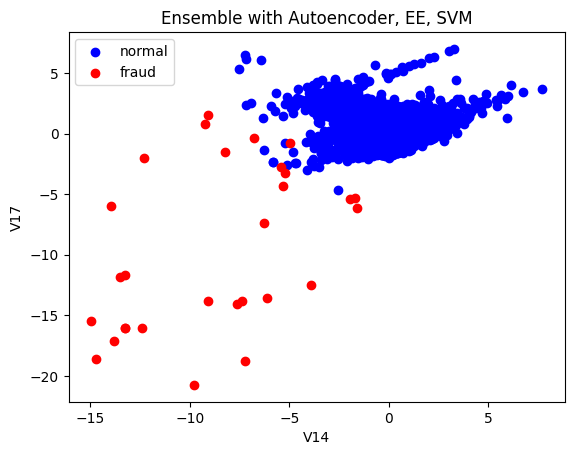

In [126]:
plt.scatter(val_df[preds==0]['V14'], val_df[preds==0]['V17'], color='blue', label='normal')
plt.scatter(val_df[preds==1]['V14'], val_df[preds==1]['V17'], color='red', label='fraud')
plt.title("Ensemble with Autoencoder, EE, SVM")
plt.xlabel("V14")
plt.ylabel("V17")
plt.legend()

plt.show()